In [52]:
import pennylane as qml
import os
import pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import matplotlib.pyplot as plt
from qiskit import *

from jax import numpy as jnp
import sympy
import matplotlib.pyplot as plt
import base64
import pickle


 # Using pennylane's wrapped numpy
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint
import jax
import numpy as np
from jax import random
import scipy
import pickle
import base64
import time
import os
import ast
import pandas as pd
from pathlib import Path
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
from functools import partial
from pennylane import numpy as pnp
from jax import config
import optax
from pennylane.transforms import transform
from typing import Sequence, Callable, Union, List
from itertools import chain
from functools import partial, singledispatch

import os
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from jax import jit
import pennylane as qml
import time
import pandas as pd
metrics_info = {
    # --- Per-draw Metrics ---
    "QFIM_ranks": {
        "title": "QFIM Ranks per Draw",
        "label": r"$\mathrm{Rank}(Q)$",
        "description": (
            "The number of nonzero eigenvalues (above the threshold) for each draw. "
            "This represents the effective number of independent directions captured by the QFIM."
        )
    },
    "var_all_eigenvals_per_draw": {
        "title": "Variance of All Eigenvalues per Draw",
        "label": r"$\mathrm{Var}(\lambda)$",
        "description": (
            "The variance computed over all eigenvalues for each QFIM draw. "
            "This measures the overall dispersion of the eigenvalue distribution on an absolute scale."
        )
    },
    "var_nonzero_eigenvals_per_draw": {
        "title": "Variance of Nonzero Eigenvalues per Draw",
        "label": r"$\mathrm{Var}_{nz}(\lambda)$",
        "description": (
            "The variance computed only over the eigenvalues that exceed the threshold for each draw. "
            "This metric reflects the dispersion of the significant eigenvalues."
        )
    },
    "trace_eigenvals_per_draw": {
        "title": "Trace of Eigenvalues per Draw",
        "label": r"$\mathrm{Tr}(Q)$",
        "description": (
            "The sum of the eigenvalues for each draw, quantifying the total magnitude of the QFIM."
        )
    },
    "var_norm_rank_per_draw": {
        "title": "Variance Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The variance (over all eigenvalues) divided by the number of nonzero eigenvalues (i.e. the rank) for each draw. "
            "It provides an estimate of the average dispersion per active mode."
        )
    },
    "trace_norm_rank_per_draw": {
        "title": "Trace Normalized by Rank per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "The trace (sum of eigenvalues) divided by the rank for each draw. "
            "It represents the average contribution per active eigenmode."
        )
    },

    # --- Aggregated (Absolute Scale) Metrics ---
    "D_C": {
        "title": "Maximum QFIM Rank (D_C)",
        "label": r"$D_C$",
        "description": (
            "The maximum rank observed across all draws. This serves as a simple estimate of the model's "
            "maximum effective capacity."
        )
    },
    "absolute_scale_avg_var_all": {
        "title": "Average Variance (All Eigenvalues)",
        "label": r"$\langle \mathrm{Var}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over all eigenvalues across draws, reflecting the typical spread "
            "of the eigenvalue distributions on an absolute scale."
        )
    },
    "absolute_scale_avg_var_nonzero": {
        "title": "Average Variance (Nonzero Eigenvalues)",
        "label": r"$\langle \mathrm{Var}_{nz}(\lambda) \rangle$",
        "description": (
            "The mean variance computed over only the nonzero eigenvalues across draws, measuring the typical "
            "dispersion among the significant eigenvalues."
        )
    },
    "absolute_scale_avg_trace": {
        "title": "Average Trace of Eigenvalues",
        "label": r"$\langle \mathrm{Tr}(Q) \rangle$",
        "description": (
            "The average sum of the eigenvalues across all draws, indicating the typical total information content "
            "in the QFIM."
        )
    },
    "absolute_scale_var_of_var_all": {
        "title": "Variance of Variance (All Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}(\lambda))$",
        "description": (
            "The variance of the per-draw variances (over all eigenvalues), which quantifies the consistency "
            "of the eigenvalue spread across different draws."
        )
    },
    "absolute_scale_var_of_var_nonzero": {
        "title": "Variance of Variance (Nonzero Eigenvalues)",
        "label": r"$\mathrm{Var}(\mathrm{Var}_{nz}(\lambda))$",
        "description": (
            "The variance of the per-draw variances computed over nonzero eigenvalues, indicating the consistency "
            "of the spread among significant eigenvalues."
        )
    },

    # --- Local Dimension Metrics (Spectrum Shape) ---
    # IPR-based:
    "spectrum_shape_ipr_deffs_norm_per_draw": {
        "title": "Normalized IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{norm}}$",
        "description": (
            "The normalized inverse participation ratio for each draw, calculated as 1/sum(norm(eigenvalues)^2) "
            "after dividing by the trace. It captures the effective number of active modes based solely on the shape "
            "of the eigenvalue spectrum."
        )
    },
    "spectrum_shape_avg_ipr_deffs_norm": {
        "title": "Average Normalized IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{norm}} \rangle$",
        "description": (
            "The average normalized IPR over all draws, representing an overall measure of the effective number of modes "
            "(ignoring total magnitude) in the QFIM."
        )
    },
    "ipr_deffs_raw_per_draw": {
        "title": "Raw IPR Dimension per Draw",
        "label": r"$\mathrm{IPR}_{\mathrm{raw}}$",
        "description": (
            "The raw inverse participation ratio, computed as $(\mathrm{Tr}(Q))^2 / \sum \lambda_i^2$, for each draw. "
            "This gives an absolute-scale estimate of the effective number of modes."
        )
    },
    "avg_ipr_deffs_raw": {
        "title": "Average Raw IPR Dimension",
        "label": r"$\langle \mathrm{IPR}_{\mathrm{raw}} \rangle$",
        "description": (
            "The mean of the raw IPR values over all draws, summarizing the absolute effective dimensionality of the QFIM."
        )
    },
    # Abbas-based:
    "spectrum_shape_abbas_deffs_norm_per_draw": {
        "title": "Normalized Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas}$",
        "description": (
            "The normalized Abbas effective dimension for each draw, computed by summing the logarithms of (1 + α·λ) "
            "after normalizing by the trace. It quantifies the effective dimension based on the eigenvalue spectrum's shape."
        )
    },
    "spectrum_shape_avg_abbas_deffs_norm": {
        "title": "Average Normalized Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas} \rangle$",
        "description": (
            "The average of the normalized Abbas dimensions across draws, providing an overall measure of the model's "
            "effective dimensionality according to the Abbas method."
        )
    },
    "abbas_deffs_raw_per_draw": {
        "title": "Raw Abbas Dimension per Draw",
        "label": r"$d_{\mathrm{eff}}^{abbas, raw}$",
        "description": (
            "The raw Abbas dimension for each draw, computed as the sum of log(1 + α·λ) over all eigenvalues. "
            "This metric measures the effective dimension in absolute terms."
        )
    },
    "avg_abbas_deffs_raw": {
        "title": "Average Raw Abbas Dimension",
        "label": r"$\langle d_{\mathrm{eff}}^{abbas, raw} \rangle$",
        "description": (
            "The mean raw Abbas dimension across draws, summarizing the overall effective dimension in absolute scale."
        )
    },
    "abbas_deffs_simple": {
        "title": "Simple Abbas Dimension",
        "label": r"$d_{\mathrm{eff}}^{abbas, simple}$",
        "description": (
            "A simplified effective dimension computed by an alternative approach (e.g. using an IPR-based method) "
            "on the eigenvalues. This serves as an alternative estimate of the model's effective capacity."
        )
    },

    # --- Average Per Active Mode Metrics ---
    "avg_per_active_mode_var_norm_rank_per_draw": {
        "title": "Variance per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the variance of all eigenvalues divided by the rank (i.e. number of nonzero eigenvalues), "
            "indicating the average dispersion per active mode."
        )
    },
    "avg_per_active_mode_trace_norm_rank_per_draw": {
        "title": "Trace per Active Mode per Draw",
        "label": r"$\frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)}$",
        "description": (
            "For each draw, the trace of the eigenvalues divided by the rank. This gives the average contribution per "
            "active eigenmode."
        )
    },
    "avg_per_active_mode_avg_var_norm_rank": {
        "title": "Average Variance per Active Mode",
        "label": r"$\langle \frac{\mathrm{Var}(\lambda)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the variance-per-rank values over all draws, reflecting the typical dispersion per active mode."
        )
    },
    "avg_per_active_mode_avg_trace_norm_rank": {
        "title": "Average Trace per Active Mode",
        "label": r"$\langle \frac{\mathrm{Tr}(Q)}{\mathrm{Rank}(Q)} \rangle$",
        "description": (
            "The average of the trace-per-rank values over all draws, representing the typical signal per active mode."
        )
    },

    # --- Spread-of-Log Metrics ---
    "spread_mean_per_sample_variance_normal": {
        "title": "Mean Spread-of-Log (Variance Method)",
        "label": r"$\mu_{\mathrm{spread}}^{Var}$",
        "description": (
            "The mean of the spread-of-log values computed using the variance method. This metric quantifies "
            "the average dispersion of the logarithms of the normalized eigenvalues."
        )
    },
    "spread_std_per_sample_variance_normal": {
        "title": "Standard Deviation of Spread-of-Log (Variance Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{Var}$",
        "description": (
            "The standard deviation of the spread-of-log values (via the variance method) across each draw, "
            "indicating the variability in the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_variance_normal": {
        "title": "Pooled Spread-of-Log (Variance Method)",
        "label": r"$S_{\mathrm{spread}}^{Var}$",
        "description": (
            "A single pooled value computed from the spread-of-log (variance method) over all draws, summarizing "
            "the overall dispersion of the normalized eigenvalue distribution."
        )
    },
    "spread_mean_per_sample_mad_normal": {
        "title": "Mean Spread-of-Log (MAD Method)",
        "label": r"$\mu_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The mean of the spread-of-log values computed using the median absolute deviation (MAD) method. "
            "It provides an alternative measure of the dispersion of the normalized eigenvalue spectrum."
        )
    },
    "spread_std_per_sample_mad_normal": {
        "title": "Standard Deviation of Spread-of-Log (MAD Method)",
        "label": r"$\sigma_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The standard deviation of the spread-of-log values computed via the MAD method, reflecting the variability "
            "of the eigenvalue dispersion."
        )
    },
    "spread_val_pooled_mad_normal": {
        "title": "Pooled Spread-of-Log (MAD Method)",
        "label": r"$S_{\mathrm{spread}}^{MAD}$",
        "description": (
            "The pooled spread-of-log metric computed using the MAD method, representing the overall dispersion of the "
            "normalized eigenvalue distribution."
        )
    },

    # --- Global Dimension Metrics ---
    "global_effective_dimension": {
        "title": "Global Effective Dimension",
        "label": r"$d_{\mathrm{eff}}^{global}$",
        "description": (
            "The effective dimension computed using a global method (e.g. from the averaged full QFIM matrix via the "
            "log-determinant approach). It quantifies the overall capacity of the model when considering all draws collectively."
        )
    },
    "fisher_trace": {
        "title": "Fisher Trace of the Averaged QFIM",
        "label": r"$\mathrm{Tr}(\bar{F})$",
        "description": (
            "The trace of the average (empirical) full QFIM matrix. This value is used as the normalization factor in "
            "the global effective dimension calculation and reflects the overall magnitude of the QFIM."
        )
    },
}
# Show all rows (no truncation):
pd.set_option('display.max_rows', None)

# (Optional) Show all columns (no column truncation):
pd.set_option('display.max_columns', None)

# (Optional) Allow columns to be as wide as needed:
pd.set_option('display.width', None)

#from pennylane.pulse import ParametrizedEvolution, ParametrizedHamiltonian,HardwareHamiltonian
from jax.experimental.ode import odeint

has_jax = True
diable_jit = False
config.update('jax_disable_jit', diable_jit)
#config.parse_flags_with_absl()
config.update("jax_enable_x64", True)
os.environ['JAX_TRACEBACK_FILTERING'] = 'off'
# global_cache_data = None
# global_processed_files = None
# from dqfim_store import metrics_info

In [86]:
from dqfim_store import get_cached_data_dqfim,maybe_rebuild_or_process_dqfim
import pandas as pd
from IPython.display import display  # Ensure this is not overwritten elsewhere

base_path = "/Users/sophieblock/QRCcapstone/parameter_analysis_directory/"
model_type = "gate"
N_ctrls = [1,2,3]
num_L = 20
sample_range = "pi"
K_str = "1b"
threshold = 1e-8
by_test = False

def rebuild_df_from_existing_cache(base_path,model_type,N_ctrls, K_0,sample_range, L):
    """
    Rebuild a single DataFrame from the cached_data dictionaries saved on disk.
    This does NOT require scanning the original QFIM_results directories.
    
    Parameters:
    -----------
    base_path : Path or str
        The base directory where cached pickles are stored.
    N_ctrls : list of int
        List of N_ctrl values you want to load from cache.
    K_0 : str or int
        The K string/index used in naming the cache files, e.g. '1', '2', etc.

    Returns:
    --------
    df_all : pd.DataFrame
        A DataFrame constructed by concatenating all 'processed_data'
        entries from each cached_data for all given N_ctrls.
    """
    all_data = []

    for N_ctrl in N_ctrls:
        cdata, pfiles = get_cached_data_dqfim(base_path,model_type, N_ctrl, K_0,sample_range,L)
        for file_id, file_info in cdata.items():
            pdata = file_info.get('processed_data', {})
            all_data.append(pdata)

    df_all = pd.DataFrame(all_data)
    return df_all


df_all = rebuild_df_from_existing_cache(base_path,model_type, N_ctrls, K_str,sample_range, num_L)
print("[INFO] df_all shape:", df_all.shape)
# /Users/sophieblock/QRCCapstone/parameter_analysis_directory/digital_new_QFIM_Nc_1_1K.pkl

df_all.columns

[WARN] No DQFIM cache for N_ctrl=1 at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_DQFIM_Nc_1_1bK_sample_pi_L20.pkl. Returning empty.
[INFO] Loaded DQFIM cache for N_ctrl=2 from /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_DQFIM_Nc_2_1bK_sample_pi_L20.pkl, num files: 29.
[WARN] No DQFIM cache for N_ctrl=3 at /Users/sophieblock/QRCcapstone/parameter_analysis_directory/gate_DQFIM_Nc_3_1bK_sample_pi_L20.pkl. Returning empty.
[INFO] df_all shape: (29, 8)


Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys',
       'key_pair_tuple'],
      dtype='object')

In [13]:
from scipy.stats import median_abs_deviation

def spread_pooling_vectorized(eigs_2d, method="variance", threshold=1e-12, ddof=1, scale="normal"):
    flat = eigs_2d.ravel()
    filtered = flat[flat>threshold]
    if filtered.size <= 1:
        return 0.0
    s = filtered.sum()
    filtered /= s
    with np.errstate(divide='ignore'):
        logs = np.log(filtered)
    return compute_spread_metric(logs, method=method, ddof=ddof, scale=scale)

def compute_spread_metric(values, method="variance", ddof=1, scale="normal"):
    """
    1D array 'values' => compute variance, mad, or median.
    """
    if len(values) <= 1:
        return 0.0
    if method == "variance":
        return np.var(values, ddof=ddof)
    elif method == "mad":
        return median_abs_deviation(values,center=np.median, scale=scale)
    elif method == "median":
        return np.median(values)
    else:
        raise ValueError(f"Unknown method: {method}")
def spread_per_sample_vectorized(
    eigs_2d,
    threshold,
    method="variance",
    ddof=0,
    scale="normal",
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None
):
    """
    Compute the 'spread-of-log' metric for each row in eigs_2d.
    Debug prints for the Trotter=1, n_ctrl=2, n_reserv=1 config.
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    # Normalize each row to sum=1 if it has nonzero entries
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]

    # Compute log of clipped
    with np.errstate(divide='ignore'):
        logs = np.log(clipped, out=np.zeros_like(clipped), where=(clipped > 0))

    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)

    for i in range(n_draws):
        row_nonzero = logs[i, clipped[i] > 0]
        val_count = row_nonzero.size
        # If row is empty or has 1 entry, the spread might be 0.0 by default
        computed_val = 0.0
        if val_count > 0:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)

        # Add debug prints if this is the config we suspect is weird
        # if (n_ctrl == 2 and n_reserv == 3 and trotter_step == 1):
        #     print(f"[DEBUG spread] Row {i}: method={method}, ddof={ddof}, val_count={val_count}")
        #     print(f"    raw row (normalized): {clipped[i]}")
        #     print(f"    row_nonzero logs: {row_nonzero}")
        #     print(f"    => spread={computed_val:.4f}")

        results[i] = computed_val

    return results

def spread_per_sample_vectorized_nolog(eigs_2d, threshold, method="variance", ddof=0, scale="normal", n_ctrl=None, n_reserv=None, trotter_step=None):
    """
    Compute the 'spread-of-values' metric for each row in eigs_2d without taking logarithms.
    The input eigs_2d is normalized row-wise (each row sums to 1, for nonzero rows).
    """
    clipped = np.where(eigs_2d > threshold, eigs_2d, 0.0)
    row_sums = clipped.sum(axis=1, keepdims=True)
    nonzero_mask = (row_sums[:, 0] > 0)
    clipped[nonzero_mask] = clipped[nonzero_mask] / row_sums[nonzero_mask]
    
    n_draws, d = eigs_2d.shape
    results = np.zeros(n_draws, dtype=float)
    for i in range(n_draws):
        row_nonzero = clipped[i, clipped[i] > 0]
        computed_val = 0.0
        if row_nonzero.size > 1:
            computed_val = compute_spread_metric(row_nonzero, method=method, ddof=ddof, scale=scale)
        results[i] = computed_val
    return results
def to_2d(evals_list):
    """
    evals_list is something like [eigvals_draw1, eigvals_draw2, ...]
    each eigvals_drawX is a 1D array (or list) of eigenvalues of length d.
    We stack them into shape (n_draws, d).
    """
    return np.vstack(evals_list)  # vstack each sub-list => 2D array


In [136]:
import numpy.ma as ma
import math


def compute_all_stats(
    eigval_list,
    num_samples,
    threshold=1e-12,
    spread_methods=("variance", "mad"),  # e.g. ["variance", "mad"]
    ddof=1,
    scales=["normal",1.0],
    qfim_mats_list=None,   
    dataset_sizes=None,    
    n=1,                   # overshadowed in the old code, kept for signature
    n_ctrl=None,
    n_reserv=None,
    trotter_step=None,
):
    """
    Vectorized version of stats computations over 'eigval_list' (shape [n_draws, M]).
    We remove the explicit Python for-loop for IPR, raw Abbas dimension, etc.
    and rely on NumPy's built-in array operations.

    Additionally, we compute the effective dimension in two ways:
      1) Average of single-draw dimensions across all QFIMs in qfim_mats_list.
      2) Dimension of the average normalized QFIM (i.e., average of F / trace(F)).

    Parameters
    ----------
    eigval_list : list of lists (or 2D array)
        Each row is the set of eigenvalues for one QFIM draw. shape [n_draws, M].
    threshold : float
        Zero out or mask any eigenvalues below this threshold.
    spread_methods : tuple
        e.g. ("variance", "mad"). Passed to your 'spread_per_sample_vectorized' function.
    ddof : int
        Degrees of freedom for variance computations.
    scale : str
        Scale for median_abs_deviation if "mad" is used.
    qfim_mats_list : list of 2D arrays (or None)
        If provided, we compute the 'effective_dimension' in two ways:
          (1) average of single-draw dims;
          (2) dim of average QFIM (after normalizing by trace).
    dataset_sizes : int or list of int, optional
        For Qiskit’s global ED or advanced dimension approaches. Not used here.
    n : int
        Overridden in the code below, but kept for signature consistency.
    n_ctrl, n_reserv, trotter_step : optional
        Additional metadata.

    Returns
    -------
    metrics : dict
        A dictionary with the computed statistics, including:
          * Basic per-draw stats (rank, var, trace)
          * IPR-based measures
          * Abbas-based measures
          * Spread-of-log measures
          * "effective_dimension_avg_over_draws"
          * "effective_dimension_of_mean_qfim"
    """
    # ---------------------------
    # (A) Convert eigvals to 2D array, zero out small entries
    # ---------------------------
    arr = np.array(eigval_list, dtype=float)
    # Threshold here => everything uses same arr
    arr = np.where(arr < threshold, 0.0, arr)

    # Now do argmin on the thresholded arr
    idxs = arr.argmin(axis=1)  # shape [n_draws]
    # print(f"[DEBUG] (n_ctrl={n_ctrl}, n_reserv={n_reserv}, trotter_step={trotter_step}): "
    #       f"num_samples={num_samples}, argmin indices={idxs}")

    if arr.ndim == 1:
        arr = arr[np.newaxis, :]  # Expand if user gave 1D

    n_draws, M = arr.shape
    assert n_draws == int(num_samples), f"Incorrect n_draws. Got: {n_draws}, expected: {num_samples}"
    n_draws*=num_L
    # ---------------------------
    # (B) Basic stats, vectorized
    # ---------------------------
    ranks_per_draw = np.count_nonzero(arr, axis=1)  # rank = # of nonzero
    var_all_per_draw = np.var(arr, axis=1, ddof=ddof)
    trace_per_draw = np.sum(arr, axis=1)

    # Debug if rank=0
    for i, r in enumerate(ranks_per_draw):
        if r == 0:
            print(f"[DEBUG] For (n_ctrl={n_ctrl}, n_reserv={n_reserv}, trotter_step={trotter_step}): "
                  f"draw #{i} ended up with rank=0 => arr[{i}] = {arr[i]}")
            # Alternatively, raise an error:
            # raise ValueError(f"QFIM draw {i} is rank=0! arr={arr[i]}")

    # variance of nonzero subset => masked arrays
    masked = ma.masked_where(arr <= 0.0, arr)
    var_nonzero_ma = ma.var(masked, axis=1, ddof=ddof)
    var_nonzero_per_draw = var_nonzero_ma.filled(0.0)

    var_norm_rank_per_draw = np.where(
        ranks_per_draw > 0,
        var_all_per_draw / ranks_per_draw,
        0.0
    )
    trace_norm_rank_per_draw = np.where(
        ranks_per_draw > 0,
        trace_per_draw / ranks_per_draw,
        0.0
    )

    # ---------------------------
    # (C) IPR-based dimensions
    # ---------------------------
    sum_of_squares = np.sum(arr**2, axis=1)
    ipr_raw_per_draw = np.divide(
        trace_per_draw**2, sum_of_squares,
        out=np.zeros_like(trace_per_draw),
        where=(sum_of_squares > 0)
    )

    # normalized IPR
    trace_mask = (trace_per_draw > 0)
    arr_norm = np.zeros_like(arr)
    arr_norm[trace_mask] = arr[trace_mask] / trace_per_draw[trace_mask, np.newaxis]
    sum_norm_sq = np.sum(arr_norm**2, axis=1)
    ipr_norm_per_draw = np.divide(
        1.0, sum_norm_sq,
        out=np.zeros_like(sum_norm_sq),
        where=(sum_norm_sq > 0)
    )

    # ---------------------------
    # (D) Abbas-based dimensions (raw & normalized)
    # ---------------------------
    gamma = 1.0
    if n_draws > 1 and math.log(n_draws) != 0:
        alpha = (gamma * n_draws) / (2.0 * math.log(n_draws))
    else:
        alpha = 0.0

    val_raw = 1.0 + alpha * arr
    val_raw[val_raw <= 0] = 1e-15
    abbas_raw_per_draw = np.sum(np.log(val_raw), axis=1)

    val_norm = 1.0 + alpha * arr_norm
    val_norm[val_norm <= 0] = 1e-15
    abbas_norm_per_draw = np.sum(np.log(val_norm), axis=1)

    # ---------------------------
    # (E) Simple aggregated stats
    # ---------------------------
    D_C = ranks_per_draw.max() if len(ranks_per_draw) > 0 else 0

    avg_var_all = float(var_all_per_draw.mean()) if var_all_per_draw.size > 0 else 0.0
    avg_trace   = float(trace_per_draw.mean())   if trace_per_draw.size > 0 else 0.0

    # Approach A: average the per-draw variance of nonzero
    avg_var_nonzero = float(var_nonzero_per_draw.mean()) if var_nonzero_per_draw.size > 0 else 0.0

    # "Global" approach B (flatten across draws) for raw
    global_nonzero_raw = arr[arr > 0.0]  # flatten
    if global_nonzero_raw.size > 1:
        global_var_nonzero = float(np.var(global_nonzero_raw, ddof=ddof))
    else:
        global_var_nonzero = 0.0

    # Similarly for normalized
    masked_norm = ma.masked_where(arr_norm <= 0.0, arr_norm)
    var_nonzero_norm_ma = ma.var(masked_norm, axis=1, ddof=ddof)
    var_nonzero_norm_per_draw = var_nonzero_norm_ma.filled(0.0)
    if var_nonzero_norm_per_draw.size > 0:
        avg_var_nonzero_norm = float(var_nonzero_norm_per_draw.mean())
    else:
        avg_var_nonzero_norm = 0.0

    global_nonzero_norm = arr_norm[arr_norm > 0.0]
    if global_nonzero_norm.size > 1:
        global_var_nonzero_norm = float(np.var(global_nonzero_norm, ddof=ddof))
    else:
        global_var_nonzero_norm = 0.0

    avg_var_norm_rank   = float(var_norm_rank_per_draw.mean())   if var_norm_rank_per_draw.size > 0 else 0.0
    avg_trace_norm_rank = float(trace_norm_rank_per_draw.mean()) if trace_norm_rank_per_draw.size > 0 else 0.0

    var_var_all     = float(np.var(var_all_per_draw)) if var_all_per_draw.size > 1 else 0.0
    var_var_nonzero = float(np.var(var_nonzero_per_draw)) if var_nonzero_per_draw.size > 1 else 0.0

    avg_ipr_raw  = float(ipr_raw_per_draw.mean())  if ipr_raw_per_draw.size  > 0 else 0.0
    avg_ipr_norm = float(ipr_norm_per_draw.mean()) if ipr_norm_per_draw.size > 0 else 0.0
    avg_abbas_raw  = float(abbas_raw_per_draw.mean())  if abbas_raw_per_draw.size  > 0 else 0.0
    avg_abbas_norm = float(abbas_norm_per_draw.mean()) if abbas_norm_per_draw.size > 0 else 0.0

    # ---------------------------
    # (F) NEW Approach B: average eigenvalues across draws, then variance
    # ---------------------------
    # 1) Raw
    mean_eigvals_raw = np.mean(arr, axis=0)  # shape [M]
    mean_eigvals_raw = np.where(mean_eigvals_raw < threshold, 0.0, mean_eigvals_raw)
    mean_eigvals_variance_raw = float(np.var(mean_eigvals_raw, ddof=ddof)) if mean_eigvals_raw.size > 1 else 0.0

    # -> minimum among the raw mean eigenvals
    nonzero_raw_means = mean_eigvals_raw[mean_eigvals_raw > 0.0]
    if nonzero_raw_means.size > 0:
        min_eigval_from_mean_raw = float(np.min(nonzero_raw_means))
        median_eigval_from_mean_raw = float(np.median(nonzero_raw_means))
    else:
        min_eigval_from_mean_raw = 0.0  # or np.nan, your choice

    # -> log-variance of raw mean eigenvals
    if mean_eigvals_raw.size > 1:
        valid_raw = mean_eigvals_raw[mean_eigvals_raw > 0.0]
        if valid_raw.size < 2:
            raise ValueError(f"No valid entries for log10 of raw mean eigenvalues in "
                             f"(n_ctrl={n_ctrl}, n_reserv={n_reserv}, trotter_step={trotter_step})!")
        mean_log_eigvals_variance_raw = float(np.var(np.log(valid_raw), ddof=ddof))
    else:
        mean_log_eigvals_variance_raw = 0.0

    # 2) Normalized
    mean_eigvals_norm = np.mean(arr_norm, axis=0)  # shape [M]
    mean_eigvals_norm = np.where(mean_eigvals_norm < threshold, 0.0, mean_eigvals_norm)
    mean_eigvals_variance_norm = float(np.var(mean_eigvals_norm, ddof=ddof)) if mean_eigvals_norm.size > 1 else 0.0
    nonzero_norm_means = mean_eigvals_norm[mean_eigvals_norm > 0.0]
    if nonzero_norm_means.size > 0:
        min_eigval_from_mean_norm = float(np.min(nonzero_norm_means))
    else:
        min_eigval_from_mean_norm = 0.0  # or np.nan, your choice
    # debug if all zero
    if np.all(mean_eigvals_norm == 0.0):
        print(f"[DEBUG] (n_ctrl={n_ctrl}, n_reserv={n_reserv}, trotter_step={trotter_step}): "
              f"mean_eigvals_norm is ALL ZEROS => {mean_eigvals_norm}")

    # log-variance of normalized mean eigenvals
    if mean_eigvals_norm.size > 1:
        nonzero_part_norm = mean_eigvals_norm[mean_eigvals_norm > 0.0]
        if nonzero_part_norm.size < 2:
            raise ValueError(f"No valid entries for log10 mean eigenvalues (normalized) in "
                             f"(n_ctrl={n_ctrl}, n_reserv={n_reserv}, trotter_step={trotter_step})!")
        mean_log_eigvals_variance_norm = float(np.var(np.log(nonzero_part_norm), ddof=ddof))
    else:
        mean_log_eigvals_variance_norm = 0.0
    
    # ---------------------------
    # (G) Spread-of-log metrics
    # ---------------------------
    arr_2d = arr.copy()  # shape [n_draws, M]
    spread_results = {}
    for scale_val in scales:
        for method in spread_methods:
            per_draw = spread_per_sample_vectorized(
                arr_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale_val,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean = float(per_draw.mean()) if per_draw.size > 0 else 0.0
            spread_std  = float(per_draw.std())  if per_draw.size > 1 else 0.0
            pooled_val  = float(spread_pooling_vectorized(
                arr_2d, method=method, threshold=threshold, ddof=ddof, scale=scale_val
            ))
            prefix = method.lower()
            spread_results[f"spread_mean_per_sample_{prefix}_{scale_val}"] = spread_mean
            spread_results[f"spread_std_per_sample_{prefix}_{scale_val}"]  = spread_std
            # spread_results[f"spread_val_pooled_{prefix}_{scale_val}"]      = pooled_val

    arr_norm_2d = arr_norm.copy()
    for scale_val in scales:
        for method in spread_methods:
            per_draw_norm = spread_per_sample_vectorized(
                arr_norm_2d,
                method=method,
                threshold=threshold,
                ddof=ddof,
                scale=scale_val,
                n_ctrl=n_ctrl,
                n_reserv=n_reserv,
                trotter_step=trotter_step,
            )
            spread_mean_norm = float(per_draw_norm.mean()) if per_draw_norm.size > 0 else 0.0
            spread_std_norm  = float(per_draw_norm.std())  if per_draw_norm.size > 1 else 0.0
            prefix = method.lower()
            spread_results[f"spread_normalized_{prefix}_{scale_val}"] = spread_mean_norm
            # If you want std, you can store that similarly.

    # If you also need the "no-log" version:
    per_draw_nolog = spread_per_sample_vectorized_nolog(
        arr_2d,
        method="mad",
        threshold=threshold,
        ddof=ddof,
        scale="normal",
        n_ctrl=n_ctrl,
        n_reserv=n_reserv,
        trotter_step=trotter_step,
    )
    spread_results[f"spread_metric_mad_nolog"] = (
        per_draw_nolog[0] if per_draw_nolog.size > 0 else 0.0
    )

    # ---------------------------
    # (H) Effective dimension in two ways
    # ---------------------------
    effective_dim_avg_draws = 0.0
    effective_dim_of_mean   = 0.0
    if qfim_mats_list is not None and len(qfim_mats_list) > 0:
        qfim_mats_array = np.array(qfim_mats_list, dtype=float)

        dim_each_draw = []
        F_hat_list = []
        for F_theta in qfim_mats_array:
            trF = np.trace(F_theta)
            if trF <= 0:
                dim_each_draw.append(0.0)
                F_hat_list.append(np.zeros_like(F_theta))
                continue

            eps = 1e-12
            F_hat = F_theta / trF
            eigs_F = np.linalg.eigvalsh(F_hat)
            eigs_F = np.where(eigs_F < threshold, 0.0, eigs_F)

            if n_draws > 1 and math.log(n_draws) != 0:
                z_i = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_F + eps))
                d_i = (2.0 / np.log(n_draws)) * z_i
            else:
                d_i = np.sum(eigs_F / (1.0 + eigs_F))

            dim_each_draw.append(d_i)
            F_hat_list.append(F_hat)

        effective_dim_avg_draws = float(np.mean(dim_each_draw))
        F_hat_mean = np.mean(F_hat_list, axis=0)
        eigs_mean = np.linalg.eigvalsh(F_hat_mean)
        eigs_mean = np.where(eigs_mean < threshold, 0.0, eigs_mean)
        eps = 1e-12
        if n_draws > 1 and math.log(n_draws) != 0:
            z_mean = 0.5 * np.sum(np.log(1.0 + n_draws * eigs_mean + eps))
            effective_dim_of_mean = (2.0 / np.log(n_draws)) * z_mean
        else:
            effective_dim_of_mean = np.sum(eigs_mean / (1.0 + eigs_mean))

    # Compute average min nonzero eigenvalue across draws
    with np.errstate(invalid='ignore'):
        arr_for_min = np.where(arr > 0.0, arr, np.nan)  # turn zeros into NaN
        min_eigs_per_draw = np.nanmin(arr_for_min, axis=1)
    avg_min_nonzero_eig = float(np.nanmean(min_eigs_per_draw)) if min_eigs_per_draw.size > 0 else 0.0
    # ----------------------------------------------------------------
    # (I) Compare min-index row-by-row to 'idxs'
    # ----------------------------------------------------------------
    # We do the same thresholded arr to find row-by-row min among all columns (including zeros).
    # We'll assert it matches `idxs`.
    min_indices = []
    for i in range(num_samples):
        row = arr[i]
        # row might be all zeros => we already raised for rank=0, so it must have >0 somewhere
        # But if the official 'argmin' can pick a zero?
        # We do direct: idx = np.argmin(row)
        # This should match idxs[i], or we fail
        idx_local = np.argmin(row)  
        min_indices.append(idx_local)
    min_indices = np.array(min_indices, dtype=int)

    # Now we assert it matches idxs
    if not np.all(min_indices == idxs):
        raise ValueError(
            f"Inconsistent min-eig indices!\n"
            f"Global idxs={idxs}\n"
            f"Loop-based min_indices={min_indices}"
        )

    # ----------------------------------------------------------------
    # (J) avg_min_nonzero_eig across draws
    # ----------------------------------------------------------------
    arr_for_min = np.where(arr>0.0, arr, np.nan)
    per_draw_min = np.nanmin(arr_for_min, axis=1)
    # print(per_draw_min)
    avg_min_nonzero_eig = float(np.nanmean(per_draw_min))
    median_min_nonzero_eigenvalue = float(np.nanmedian(min_eigs_per_draw)) if min_eigs_per_draw.size>0 else 0.0


    metrics = {
        # Per-draw lists
        "QFIM_ranks": ranks_per_draw,
        "var_all_eigenvals_per_draw": var_all_per_draw,
        "var_nonzero_eigenvals_per_draw": var_nonzero_per_draw,
        "trace_eigenvals_per_draw": trace_per_draw,
        "min_eigs_per_draw":min_eigs_per_draw,

        # Aggregates
        "D_C": D_C,
        "Redundancy":(M-D_C)/M,
        "absolute_scale_avg_var_all": avg_var_all,
        "absolute_scale_avg_var_nonzero": avg_var_nonzero,
        "normalized_avg_var_nonzero": avg_var_nonzero_norm,

        "absolute_scale_global_var_nonzero": global_var_nonzero,
        "normalized_global_var_nonzero":     global_var_nonzero_norm,
        "absolute_scale_avg_trace": avg_trace,
        "absolute_scale_var_of_var_all": var_var_all,
        "absolute_scale_var_of_var_nonzero": var_var_nonzero,

        "avg_per_active_mode_var_norm_rank_per_draw": var_norm_rank_per_draw,
        "avg_per_active_mode_trace_norm_rank_per_draw": trace_norm_rank_per_draw,
        "avg_per_active_mode_avg_var_norm_rank": float(avg_var_norm_rank),
        "avg_per_active_mode_avg_trace_norm_rank": float(avg_trace_norm_rank),

        # IPR draws & means
        "ipr_deffs_raw_per_draw": ipr_raw_per_draw,
        "spectrum_shape_avg_ipr_deffs_raw": float(avg_ipr_raw),
        "ipr_deffs_norm_per_draw": ipr_norm_per_draw,
        "spectrum_shape_avg_ipr_deffs_norm": float(avg_ipr_norm),

        # Abbas draws & means
        "abbas_deffs_raw_per_draw": abbas_raw_per_draw,
        "avg_abbas_deffs_raw": float(avg_abbas_raw),
        "abbas_deffs_norm_per_draw": abbas_norm_per_draw,
        "avg_abbas_deffs_norm": float(avg_abbas_norm),

        # Approach B: mean eigenvalues
        "mean_eigvals_raw": mean_eigvals_raw,
        "mean_eigvals_variance_raw": mean_eigvals_variance_raw,
        "mean_log_eigvals_variance_raw": mean_log_eigvals_variance_raw,
        "min_eigval_from_mean_raw": min_eigval_from_mean_raw,

        "mean_eigvals_norm": mean_eigvals_norm,
        "mean_eigvals_variance_norm": mean_eigvals_variance_norm,
        "mean_log_eigvals_variance_norm": mean_log_eigvals_variance_norm,
        "min_eigval_from_mean_norm": min_eigval_from_mean_norm,

        # Effective dimension (two ways)
        "effective_dimension_avg_over_draws": effective_dim_avg_draws,
        "effective_dimension_of_mean_qfim":   effective_dim_of_mean,
        "avg_min_nonzero_eigenvalue": avg_min_nonzero_eig,
        "median_min_nonzero_eigenvalue": median_min_nonzero_eigenvalue,
    }
    metrics.update(spread_results)
    return metrics

def build_qfim_dataframe(df_all, threshold):
    """
    1) Convert all_qfim_eigvals -> qfim_eigs_2d
    2) Single-pass stats => expanded columns (including spread-of-log)
    3) Optionally, extra 'compute_spread_columns' calls 
       if you want separate columns for 'median', etc.
    4) Return final df_all with everything included.
    """
    # 1) Convert for convenience
    df_all["qfim_eigs_2d"] = df_all["all_qfim_eigvals"].apply(to_2d)

    # 2) Single-pass stats
    stats_series = df_all.apply(
        lambda row: compute_all_stats(
            eigval_list=row["all_qfim_eigvals"],
            num_samples=row["num_test_keys"],
            threshold=threshold,
            spread_methods=["variance", "mad"],  # You can add "median" if desired
            ddof=1,
            scales=["normal",1.0],
            qfim_mats_list=row["all_full_qfim_mats"],
            n_ctrl=row["N_ctrl"],
            n_reserv=row["N_reserv"],
            trotter_step=row["Trotter_Step"]
        ),
        axis=1
    )

    # 3) Normalize the resulting series (which is a series of dictionaries)
    df_stats = pd.json_normalize(stats_series)

    # 4) Concatenate the original dataframe with the computed statistics
    df_out = pd.concat([df_all.reset_index(drop=True), df_stats.reset_index(drop=True)], axis=1)
    return df_out
df_with_stats = build_qfim_dataframe(df_all=df_all, threshold=1e-12)
# df_with_stats.head()

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_29086/551309474.py:310: ComplexWarning: Casting complex values to real discards the imaginary part
  qfim_mats_array = np.array(qfim_mats_list, dtype=float)


In [137]:
df_with_stats.columns

Index(['N_ctrl', 'N_reserv', 'Trotter_Step', 'all_qfim_eigvals',
       'all_full_qfim_mats', 'mean_entropy', 'num_test_keys', 'key_pair_tuple',
       'qfim_eigs_2d', 'QFIM_ranks', 'var_all_eigenvals_per_draw',
       'var_nonzero_eigenvals_per_draw', 'trace_eigenvals_per_draw',
       'min_eigs_per_draw', 'D_C', 'Redundancy', 'absolute_scale_avg_var_all',
       'absolute_scale_avg_var_nonzero', 'normalized_avg_var_nonzero',
       'absolute_scale_global_var_nonzero', 'normalized_global_var_nonzero',
       'absolute_scale_avg_trace', 'absolute_scale_var_of_var_all',
       'absolute_scale_var_of_var_nonzero',
       'avg_per_active_mode_var_norm_rank_per_draw',
       'avg_per_active_mode_trace_norm_rank_per_draw',
       'avg_per_active_mode_avg_var_norm_rank',
       'avg_per_active_mode_avg_trace_norm_rank', 'ipr_deffs_raw_per_draw',
       'spectrum_shape_avg_ipr_deffs_raw', 'ipr_deffs_norm_per_draw',
       'spectrum_shape_avg_ipr_deffs_norm', 'abbas_deffs_raw_per_draw',
      

Descr: The mean of the spread-of-log values computed using the variance method. This metric quantifies the average dispersion of the logarithms of the normalized eigenvalues.


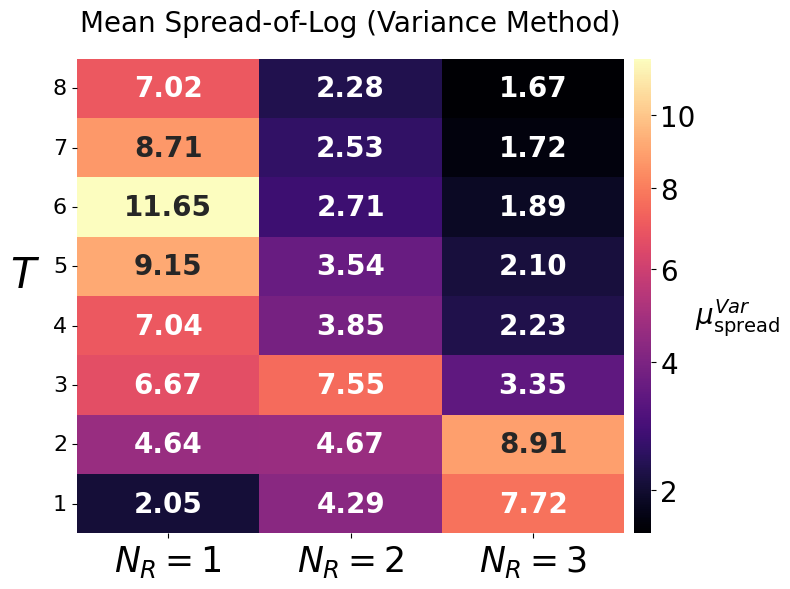

Descr: 


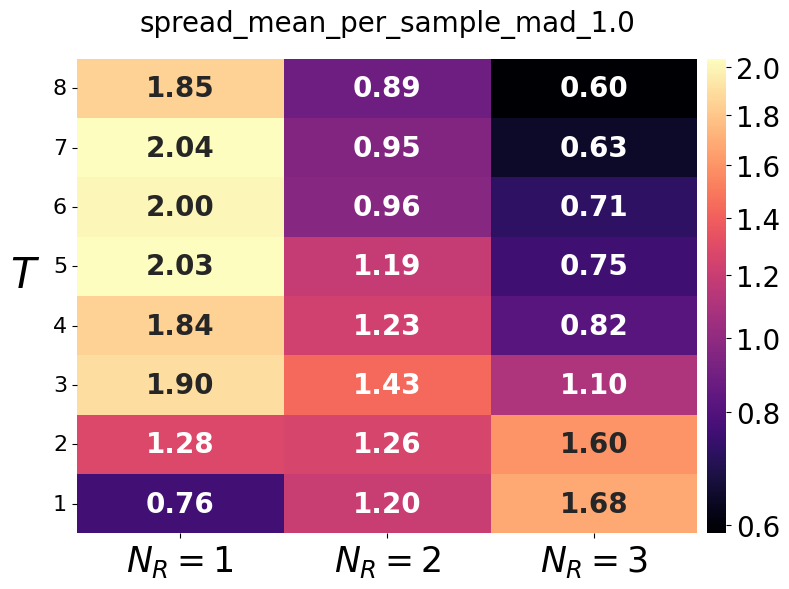

Descr: 


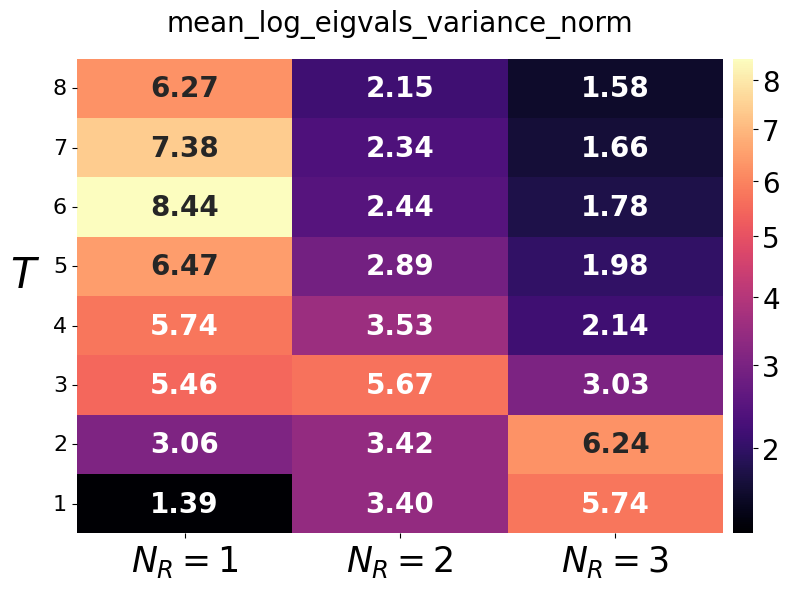

Descr: The mean raw Abbas dimension across draws, summarizing the overall effective dimension in absolute scale.


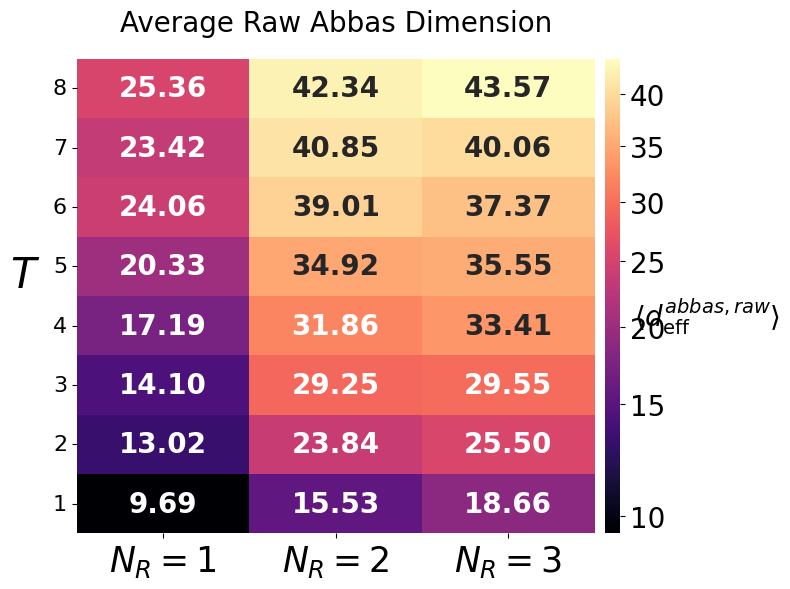

Descr: 


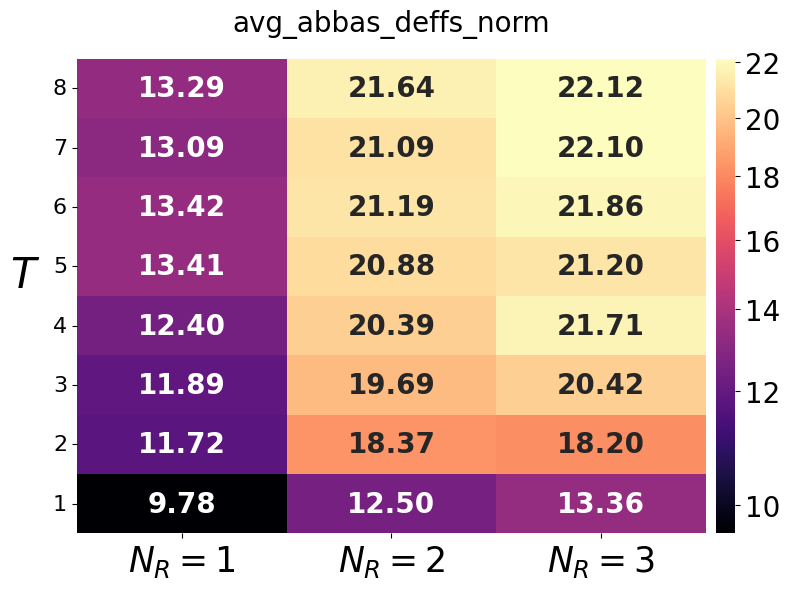

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import PowerNorm
chosen_n_ctrl=2
N_ctrl = chosen_n_ctrl
def plot_qfim_metrics_heatmaps(df_all, N_ctrl, metric_keys, metrics_info, resies=None):
    """
    Generates heatmaps for multiple metrics specified in 'metric_keys' 
    using the definitions/titles in 'metrics_info'.

    - df_all: your main DataFrame.
    - N_ctrl: the control-qubit dimension you're focusing on (int).
    - metric_keys: list of column names in df_all that you want to plot.
    - metrics_info: dict with metadata for each metric_key
    - resies: list of reservoir-qubit counts you want on the x-axis 
      (defaults to [1,2,3,4] or whatever you specify).
    """

    # 1) Default reservoir list if none provided
    if resies is None:
        resies = [1, 2, 3]

  
    # 3) Single filter step for this N_ctrl, reservoir set, and Trotter steps
    df_filtered = df_all.query("N_ctrl == @N_ctrl").copy()
    df_filtered = df_filtered[df_filtered["N_reserv"].isin(resies)]
    # df_filtered = df_filtered[df_filtered["Trotter_Step"].isin(trots)]

    # 4) Loop over each metric you want to plot
    for metric_key in metric_keys:
        if metric_key not in df_filtered.columns:
            print(f"Warning: '{metric_key}' not in df_filtered columns.")
            continue

        # Retrieve title & color bar label from your dictionary

        metric_title = metrics_info.get(metric_key, {}).get('title', metric_key)
        metric_cbar  = metrics_info.get(metric_key, {}).get('label', '')
        metric_descr  = metrics_info.get(metric_key, {}).get('description', '')
        print(f"Descr: {metric_descr}")

        # 4a) Pivot the data for a heatmap
        df_heatmap = (
            df_filtered[["N_reserv", "Trotter_Step", metric_key]]
            .groupby(["Trotter_Step", "N_reserv"])[metric_key]
            .mean()  # or .median(), .max() etc. if desired
            .reset_index()
        )
        heatmap_pivot = df_heatmap.pivot(index="Trotter_Step", columns="N_reserv", values=metric_key)

        # 4b) Compute min/max for color normalization
        min_val = heatmap_pivot.min().min()
        max_val = heatmap_pivot.max().max()

        # 4c) Create formatted annotations
        # D_C: integer ranks, so show 0 decimal places
        if metric_key == "D_C":
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.0f}")
        else:
            annotation_matrix = heatmap_pivot.map(lambda x: f"{x:.2f}")

        # 5) Plotting
        fig, ax = plt.subplots(figsize=(8, 6))

        # Create a divider to place colorbar alongside the heatmap
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.1)

        # Example: use a power-law normalization
        sns.heatmap(
            heatmap_pivot,
            annot=annotation_matrix, fmt="",  # fmt="" so we use our own annotated strings
            ax=ax, cbar_ax=cax, cmap="magma",
            annot_kws={"weight": "bold", "size": 20},
            norm=PowerNorm(gamma=0.7, vmin=min_val, vmax=max_val)
        )

        # Invert y-axis so T=1 is at the top
        ax.invert_yaxis()

        # Configure colorbar
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=20)
        cbar.set_label(metric_cbar, rotation=0, labelpad=30, fontsize=20)

        # Title & labels
        ax.set_title(metric_title, fontsize=20, pad=20)
        ax.set_ylabel('$T$', labelpad=20, fontsize=30, rotation=0)
        ax.set_xlabel("", fontsize=20)
        ax.tick_params(axis='y', labelrotation=0, labelsize=16)
        ax.tick_params(axis='x', labelsize=16)

        # Format x-tick labels
        xticklabels = [f'$N_R = {int(col)}$' for col in heatmap_pivot.columns]
        ax.set_xticklabels(xticklabels, fontweight="bold", fontsize=25, rotation=0)

        plt.tight_layout()
        plt.show()

metric_keys = ['D_C',"spectrum_shape_avg_ipr_deffs_norm",'spectrum_shape_avg_abbas_deffs_norm','avg_abbas_deffs_raw', 'spread_mean_per_sample_variance_normal', 'spread_mean_per_sample_mad_normal']
# metric_keys = ['absolute_scale_avg_var_nonzero','avg_per_active_mode_avg_var_norm_rank','spread_mean_per_sample_variance_normal']
metric_keys = ['spread_mean_per_sample_variance_normal',"spread_mean_per_sample_mad_1.0","mean_log_eigvals_variance_norm", "avg_abbas_deffs_raw","avg_abbas_deffs_norm"]
# metric_keys = ["absolute_scale_avg_var_nonzero","absolute_scale_global_var_nonzero","mean_eigvals_variance_raw","normalized_avg_var_nonzero","mean_eigvals_variance_norm"]
# 'spectrum_shape_ipr_deffs_norm_per_draw',
#        'spectrum_shape_avg_ipr_deffs_norm',
#        'spectrum_shape_abbas_deffs_norm_per_draw',
#        'spectrum_shape_avg_abbas_deffs_norm',
# metric_keys = [  'avg_abbas_deffs_norm', 'avg_abbas_deffs_raw',
#        'effective_dimension_of_mean_qfim',]



selected_T_plot = np.arange(1,9,1)
df_filtered = df_with_stats[df_with_stats['Trotter_Step'].isin(selected_T_plot)]
plot_qfim_metrics_heatmaps(df_filtered, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

Descr: The maximum rank observed across all draws. This serves as a simple estimate of the model's maximum effective capacity.


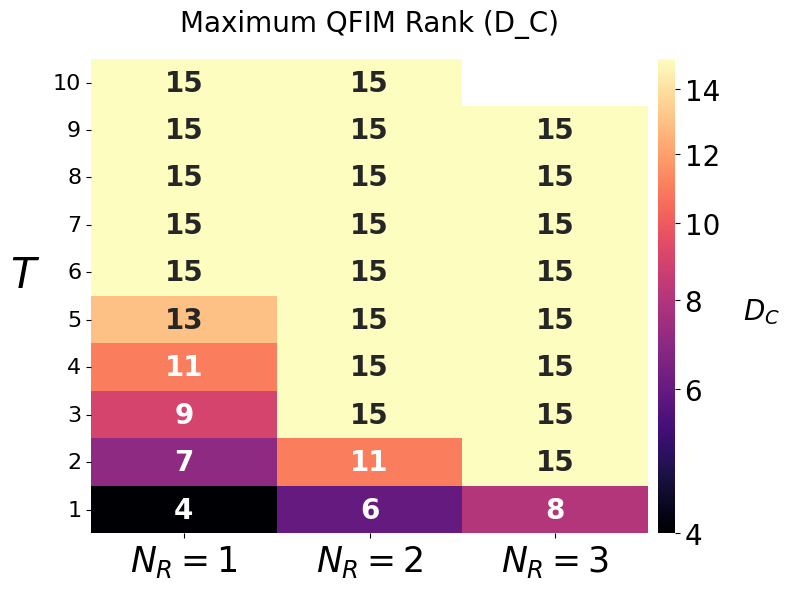

Descr: 


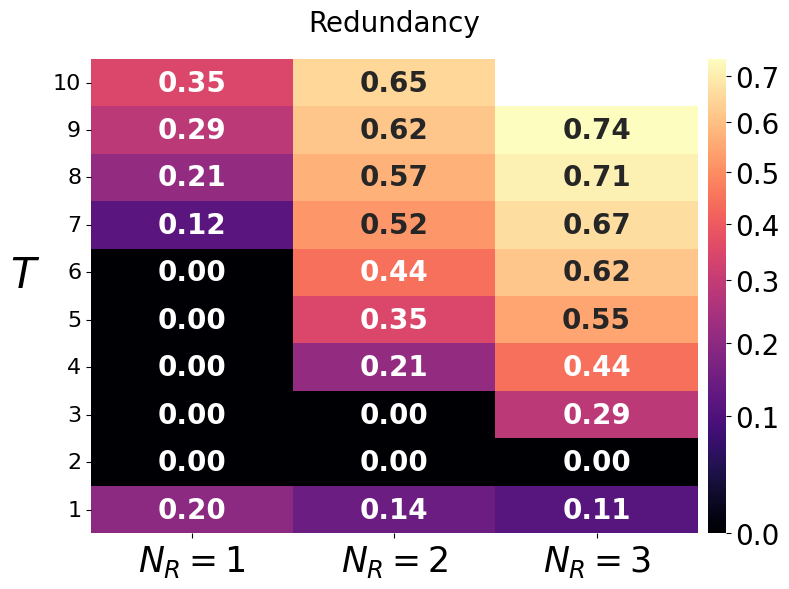

In [110]:
metric_keys = [  'D_C', 'Redundancy']
plot_qfim_metrics_heatmaps(df_with_stats, N_ctrl=chosen_n_ctrl, metric_keys=metric_keys, metrics_info=metrics_info, resies=[1,2,3,4])

[ 1  2  3  4  5  6  7 10  8  9]
[5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
[INFO] For N_ctrl=2, N_reserv=1, Detected critical T_C = 6 where M = 15
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6

[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6



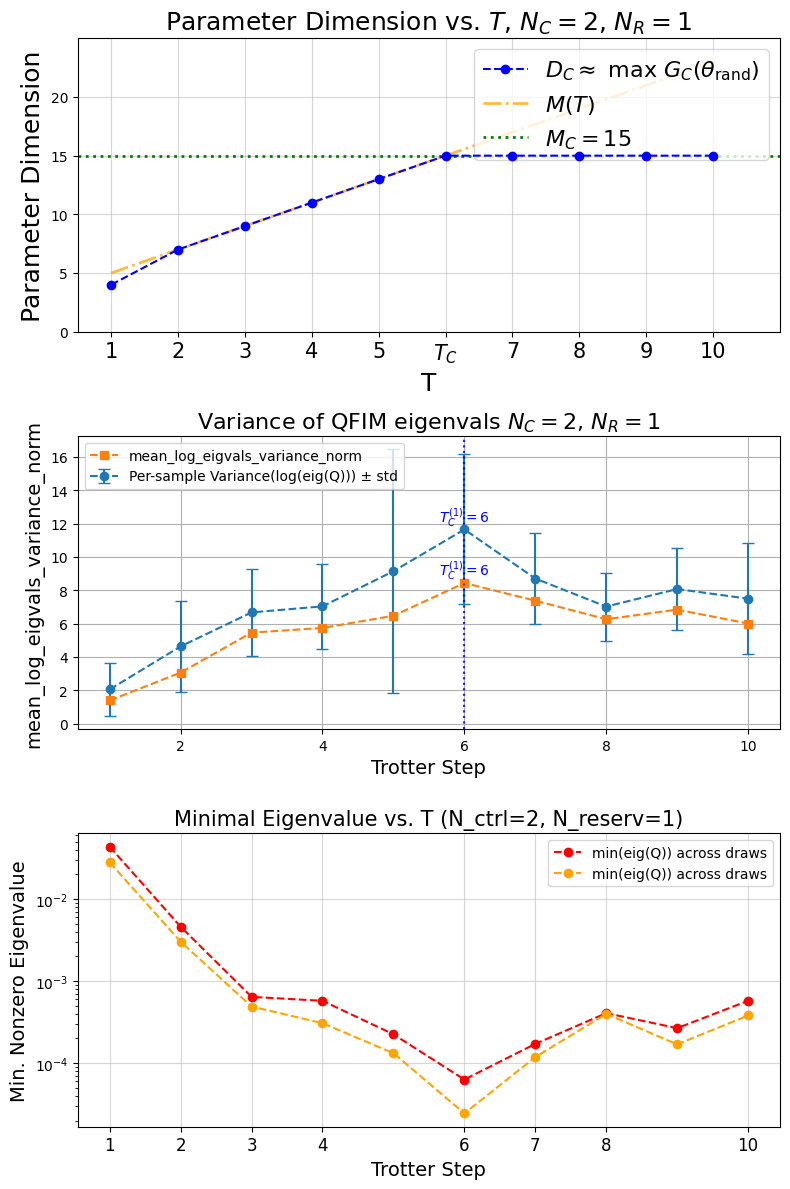

In [143]:
def plot_max_rank_vs_params(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                            xlabel='T', ylabel='Parameter Dimension', title=None,
                            color='b', param_color='orange', critical_color='green',
                            legend_loc='upper right',num_ticks=10):
    """
    Plots max rank vs. parameters for given control and reservoir values.

    Parameters:
    - df: DataFrame containing 'Trotter_Step', 'N_ctrl', 'N_reserv', 'QFIM_ranks'.
    - chosen_n_ctrl: Selected control value for filtering.
    - chosen_n_reserv: Selected reservoir value for filtering.
    - ax: Matplotlib axis to plot on (default: creates new figure).
    - xlabel, ylabel: Axis labels.
    - title: Title of the plot.
    - color: Color for max rank plot line.
    - param_color: Color for parameter dimension line.
    - critical_color: Color for the critical threshold line.
    - legend_loc: Legend location.
    """
    
    # Filter for chosen values
    subset = df[(df['N_ctrl'] == chosen_n_ctrl) & (df['N_reserv'] == chosen_n_reserv)]
    
    trotter_steps, max_ranks = [], []
    for T_step, grp in subset.groupby('Trotter_Step'):
        all_ranks = [rank for row in grp['QFIM_ranks'] for rank in row]
        max_rank = np.max(all_ranks) if all_ranks else 0
        trotter_steps.append(T_step)
        max_ranks.append(max_rank)

    # Sort data
    trotter_steps, max_ranks = zip(*sorted(zip(trotter_steps, max_ranks)))

    # Compute parameter dimension M(T)
    # param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="digital") for t in trotter_steps]
    param_list = [get_num_params(chosen_n_reserv, chosen_n_ctrl, t, model_type="digital") for t in trotter_steps]
    print(param_list)
    print(trotter_steps)
    # Detect critical T_C
    idx_C = int(np.argmax(max_ranks))
    T_C, M_C, D_C = trotter_steps[idx_C], param_list[idx_C], max_ranks[idx_C]
    print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, Detected critical T_C = {T_C} where M = {M_C}")
    # Create plot if no axis is provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Plot max rank vs. Trotter step
    ax.plot(trotter_steps, max_ranks, marker='o', linestyle='--', color=color,
            label=r'$D_C \approx$ max $G_C(\theta_{\text{rand}})$', zorder=10)
    
    # Plot M(T)
    ax.plot(trotter_steps, param_list, color=param_color, linestyle='-.',
            alpha=0.75, linewidth=2, label='$M(T)$')
    
    # Horizontal line at M_C
    ax.axhline(y=M_C, color=critical_color, linestyle=':', linewidth=2, label=f'$M_C={M_C}$')

    # X-axis ticks: evenly spaced, always including T=1 and T_C
    x_ticks = np.linspace(min(trotter_steps), max(trotter_steps), num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [1, T_C]))  # Ensure T=1 and T_C are always included

    # Labeling T_C explicitly
    xtick_labels = [f"$T_C$" if tick == T_C else str(tick) for tick in x_ticks]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xtick_labels, fontsize=15)
    


    # Y-axis: Ensure labels are integers
    yticks = list(np.arange(0, max(max_ranks) + 10, step=5))
    if M_C not in yticks:
        yticks.append(M_C)
    
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}"))

    ax.set_xlabel(xlabel, fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.legend(fontsize=16, loc=legend_loc)
    ax.grid(True, alpha=0.5)
    ax.set_ylim(top=M_C + 10)
    ax.set_xlim(left=0.5, right=max(trotter_steps)+1)
    if not title:
        title=f'Parameter Dimension vs. $T$, $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
    if title:
        ax.set_title(title, fontsize=18)

    return ax
    
def plot_spread_analysis(df, chosen_n_ctrl, chosen_n_reserv, ax=None,
                         spread_type="variance", combination="sampled",
                         show_yerr=False, title=None, xlabel="Trotter Step",
                         ylabel=None, num_ticks=6, scale='normal'):
    """
    Plots "spread" metrics or the log-variance metrics you added, with an
    annotated T_C vertical line (T_C^{(N_R)}).

    Parameters
    ----------
    df : DataFrame
        Must contain the relevant columns, e.g. for spread-based metrics:
         'spread_mean_per_sample_variance_normal', 'spread_std_per_sample_variance_normal', etc.
        or for the new log-variance keys: 'mean_log_eigvals_variance_norm', 'mean_log_eigvals_variance_raw'.
    chosen_n_ctrl : int
    chosen_n_reserv : int
    ax : matplotlib.axes.Axes
        If None, create a new figure/axes.
    spread_type : str
        One of {"variance","mad"} [older approach], or 
        one of {"mean_log_eigvals_variance_norm","mean_log_eigvals_variance_raw"} [new approach].
    combination : str
        For older approach, "sampled" or "pooled". (Ignored for log-variance.)
    show_yerr : bool
        Whether to plot error bars for the older approach (sample-based only).
    title : str
        Plot title; if None, a default is constructed.
    xlabel, ylabel : str
        Axis labels.
    num_ticks : int
        Number of x-ticks to generate (currently not used in code).
    scale : str
        'normal', or any other scale needed for older approach columns.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # 1) Filter data for the chosen N_ctrl, N_reserv
    df_plot = df.query("N_ctrl==@chosen_n_ctrl & N_reserv==@chosen_n_reserv").copy()
    df_plot.sort_values("Trotter_Step", inplace=True)

    # 2) Extract x values
    x_vals = df_plot["Trotter_Step"].values

    # Check if user is requesting the NEW log-variance approach or the older approach
    special_keys = {"mean_log_eigvals_variance_norm", "mean_log_eigvals_variance_raw", "mean_eigvals_variance_norm", "mean_eigvals_variance_raw","median_min_nonzero_eigenvalue"}

    if spread_type in special_keys:
        # === NEW: Directly plot the single column, e.g. 'mean_log_eigvals_variance_norm' ===
        if spread_type not in df_plot.columns:
            raise ValueError(f"DataFrame has no column '{spread_type}' to plot.")

        # Grab that column
        y_vals = df_plot[spread_type].values
        data_for_peak = y_vals
        data_label = spread_type

        # Identify T_C (peak) from y_vals
        peak_idx = int(np.argmax(data_for_peak))
        peak_T   = x_vals[peak_idx]
        peak_val = data_for_peak[peak_idx]
        print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
              f"peak T_C is {peak_T}\n")

        # Create plot if no axis is provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        # Actually plot
        ax.plot(x_vals, y_vals, "s--", label=data_label)

        # Annotate T_C
        ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
        ax.text(
            peak_T, peak_val + 0.1,
            fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
            fontsize=10, color='b',
            ha='center', va='bottom'
        )

        ax.set_xlabel(xlabel, fontsize=14)
        if not ylabel:
            ylabel = spread_type
        ax.set_ylabel(ylabel, fontsize=14)
        if not title:
            
            title = f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
        ax.set_title(title, fontsize=16)
        ax.grid(True)
        ax.legend()

        return ax

    else:
        # === OLD approach: spread_type in {"variance","mad"} ===
        if spread_type not in ["variance", "mad"]:
            raise ValueError("spread_type must be 'variance', 'mad', "
                             "'mean_log_eigvals_variance_norm', or 'mean_log_eigvals_variance_raw'")

        if combination not in ["pooled", "sampled"]:
            raise ValueError("combination must be 'pooled' or 'sampled'")

        # Column names for y-values
        y_mean_key = f"spread_mean_per_sample_{spread_type}_{scale}"
        y_std_key  = f"spread_std_per_sample_{spread_type}_{scale}"
        # y_pool_key = f"spread_val_pooled_{spread_type}_{scale}"  # not used if you never store it

        if y_mean_key not in df_plot.columns:
            raise ValueError(f"DataFrame has no column '{y_mean_key}' (check scale?)")

        y_mean = df_plot[y_mean_key].values
        # If the user wants error bars
        if y_std_key in df_plot.columns:
            y_std  = df_plot[y_std_key].values
        else:
            y_std  = np.zeros_like(y_mean)

        if combination == "sampled":
            data_for_peak = y_mean
            data_label = f"Per-sample {spread_type.capitalize()}(log(eig(Q)))"
        else:  # "pooled"
            raise NotImplementedError("Pooled array logic is not implemented. "
                                      "If you have a 'spread_val_pooled_{spread_type}_{scale}' column, handle here.")

        # Identify peak (T_C)
        peak_idx = int(np.argmax(data_for_peak))
        peak_T   = x_vals[peak_idx]
        peak_val = data_for_peak[peak_idx]
        print(f"[INFO] For N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv}, "
              f"peak T_C is {peak_T}\n")

        # Create plot if no axis is provided
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 6))

        # Actually plot
        if combination == "sampled":
            if show_yerr:
                ax.errorbar(
                    x_vals, y_mean, yerr=y_std, fmt="o--",
                    capsize=4, label=f"{data_label} ± std"
                )
            else:
                ax.plot(
                    x_vals, y_mean, "s--", label=data_label
                )
        # else: handle "pooled" if you store that in df

        # Annotate T_C
        ax.axvline(x=peak_T, color='b', linestyle=':', alpha=0.6)
        ax.text(
            peak_T, peak_val + 0.1,
            fr"$T_C^{{({chosen_n_reserv})}}={peak_T}$",
            fontsize=10, color='b',
            ha='center', va='bottom'
        )

        ax.set_xlabel(xlabel, fontsize=14)
        if not ylabel:
            ylabel = f"{spread_type.upper()}(log(eig(F)))"
        ax.set_ylabel(ylabel, fontsize=14)
        if not title:
            title = f'Variance of QFIM eigenvals $N_C = {chosen_n_ctrl}$, $N_R = {chosen_n_reserv}$'
        ax.set_title(title or f"{spread_type.capitalize()}-based Spread Analysis", fontsize=16)
        ax.grid(True)
        ax.legend()

        return ax

def get_num_params(N_r, N_c, T, model_type = 'digital'):
        if model_type == 'analog':
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
             raise TypeError(f'No model type: {model_type}')
def plot_min_eigenvalue_vs_t(df, chosen_n_ctrl, chosen_n_reserv, y_metric='min_eigval_from_mean_raw',ax=None,
                             xlabel="Trotter Step", ylabel="Min. Nonzero Eigenvalue",
                             title=None, use_log_y=True, num_ticks=8, marker='o', color='r'):
    """
    Plot the 'avg_min_nonzero_eigenvalue' vs. Trotter step for a given (N_ctrl,N_reserv).
    This matches figure (c) style in the referenced paper.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'N_ctrl','N_reserv','Trotter_Step','avg_min_nonzero_eigenvalue'.
    chosen_n_ctrl : int
        The N_ctrl to filter on.
    chosen_n_reserv : int
        The N_reserv to filter on.
    ax : matplotlib.axes.Axes (optional)
        Axis to draw on. If None, creates a new figure+axis.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title.
    use_log_y : bool
        Whether to use a log scale for the y-axis (often useful for small eigenvals).
    num_ticks : int
        Number of x-ticks to show.
    marker, color : styling
        Marker style, color for the line.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # 1) Filter
    subset = df[(df["N_ctrl"] == chosen_n_ctrl) & (df["N_reserv"] == chosen_n_reserv)].copy()
    if "avg_min_nonzero_eigenvalue" not in subset.columns:
        raise ValueError(f"DataFrame must have '{y_metric}' from compute_all_stats().")

    # 2) Sort by trotter step
    subset.sort_values("Trotter_Step", inplace=True)
    x_vals = subset["Trotter_Step"].values
    y_vals = subset[y_metric].values

    # 3) Create axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 5))

    # 4) Plot
    ax.plot(x_vals, y_vals, marker=marker, color=color, linestyle='--',
            label="min(eig(Q)) across draws")

    # 5) Set axis scale, ticks
    if use_log_y:
        ax.set_yscale('log')

    # X ticks
    x_min, x_max = min(x_vals), max(x_vals)
    x_ticks = np.linspace(x_min, x_max, num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [x_min, x_max]))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], fontsize=12)

    # 6) Labeling
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if not title:
        title = f"Minimal Eigenvalue vs. T (N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv})"
    ax.set_title(title, fontsize=15)
    ax.grid(True, alpha=0.5)
    ax.legend()
    return ax

def plot_redundancy_vs_t(df, chosen_n_ctrl, chosen_n_reserv, model_type='digital',
                         ax=None, xlabel="T", ylabel=r"$(M(T)-D_C) / M(T)$",
                         title=None, num_ticks=8, marker='o', color='g'):
    """
    Plot 'redundancy' = D_C / M(T) vs. Trotter step, 
    where D_C is from df['D_C'], and M(T) is get_num_params(N_reserv, N_ctrl, T).

    This loosely replicates a dimension-likeness ratio you might see in the paper.

    Parameters
    ----------
    df : pd.DataFrame
        Must have columns 'N_ctrl','N_reserv','Trotter_Step','D_C'.
    chosen_n_ctrl : int
        The control qubit count to filter on.
    chosen_n_reserv : int
        The reservoir qubit count to filter on.
    model_type : str
        "digital" or "analog" for get_num_params.
    ax : matplotlib.axes.Axes, optional
        Axis to plot on; if None, make a new figure.
    xlabel, ylabel : str
        Axis labels.
    title : str
        Plot title.
    num_ticks : int
        # of x ticks to draw.
    marker, color : styling
        Plot style.

    Returns
    -------
    ax : matplotlib.axes.Axes
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Reuse your function for M(T)
    def get_num_params(N_r, N_c, T, model_type='digital'):
        if model_type == 'analog':
            # example formula
            return N_r * N_c * T + 3 + T
        elif model_type == 'digital':
            return N_r * N_c * T + 3
        else:
            raise ValueError(f"Unknown model type: {model_type}")

    # 1) Filter
    subset = df[(df["N_ctrl"] == chosen_n_ctrl) & (df["N_reserv"] == chosen_n_reserv)].copy()
    if "D_C" not in subset.columns:
        raise ValueError("DataFrame must have 'D_C' from compute_all_stats().")

    # 2) Sort by T
    subset.sort_values("Trotter_Step", inplace=True)
    T_vals = subset["Trotter_Step"].values
    DC_vals = subset["D_C"].values  # dimension across draws

    # 3) Compute redundancy = D_C / M(T)
    redundancies = []
    for T, DC in zip(T_vals, DC_vals):
        M_T = get_num_params(chosen_n_reserv, chosen_n_ctrl, T, model_type=model_type)
        if M_T == 0:
            redundancies.append(np.nan)
        else:
            redundancies.append((M_T-DC) / M_T)

    redundancies = np.array(redundancies, dtype=float)

    # 4) Create axis if needed
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,5))

    # 5) Plot
    ax.plot(T_vals, redundancies, marker=marker, color=color,
            label=f'$N_R={chosen_n_reserv}$', linestyle='--')

    # 6) Ticks & labeling
    x_min, x_max = min(T_vals), max(T_vals)
    x_ticks = np.linspace(x_min, x_max, num=num_ticks, dtype=int)
    x_ticks = np.unique(np.append(x_ticks, [x_min, x_max]))
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(x) for x in x_ticks], fontsize=12)

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if not title:
        title = f"Redundancy vs. T (N_ctrl={chosen_n_ctrl}, N_reserv={chosen_n_reserv})"
    ax.set_title(title, fontsize=15)
    ax.grid(True, alpha=0.5)
    ax.legend()
    return ax
chosen_n_reserv = 1
chosen_n_ctrl = 2
print(df_with_stats['Trotter_Step'].unique())
selected_T_plot = np.arange(1,11,1)
df_filtered = df_with_stats[df_with_stats['Trotter_Step'].isin(selected_T_plot)]
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig, axes = plt.subplots(3, 1, figsize=(8, 12))
plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, ax=axes[0])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="mad", combination="sampled", scale='normal',ax=axes[1])
plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance",show_yerr=True, combination="sampled", scale='normal',ax=axes[1])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv, spread_type="variance", combination="sampled",scale=1.0, ax=axes[1])
plot_spread_analysis(
    df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv,
    spread_type="mean_log_eigvals_variance_norm",
    ax=axes[1]
)

plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv,y_metric='min_eigval_from_mean_raw',  ax=axes[2],
                         use_log_y=True, color='r')
plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv,y_metric='median_min_nonzero_eigenvalue',  ax=axes[2],
                         use_log_y=True, color='orange')
# plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv,y_metric='min_eigval_from_mean_norm',  ax=axes[2],
#                          use_log_y=True, color='r')
                        #  median_min_eig_index_across_draws
# plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=chosen_n_ctrl, chosen_n_reserv=chosen_n_reserv,y_metric='avg_min_nonzero_eigenvalue',  ax=axes[2],
#                          use_log_y=True, color='green')

plt.tight_layout()
plt.show()

[5, 7, 9, 11, 13, 15, 17, 19, 21, 23]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
[INFO] For N_ctrl=2, N_reserv=1, Detected critical T_C = 6 where M = 15
[INFO] For N_ctrl=2, N_reserv=1, peak T_C is 6

[7, 11, 15, 19, 23, 27, 31, 35, 39, 43]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
[INFO] For N_ctrl=2, N_reserv=2, Detected critical T_C = 3 where M = 15
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 3

[9, 15, 21, 27, 33, 39, 45, 51, 57]
(1, 2, 3, 4, 5, 6, 7, 8, 9)
[INFO] For N_ctrl=2, N_reserv=3, Detected critical T_C = 2 where M = 15
[INFO] For N_ctrl=2, N_reserv=3, peak T_C is 2



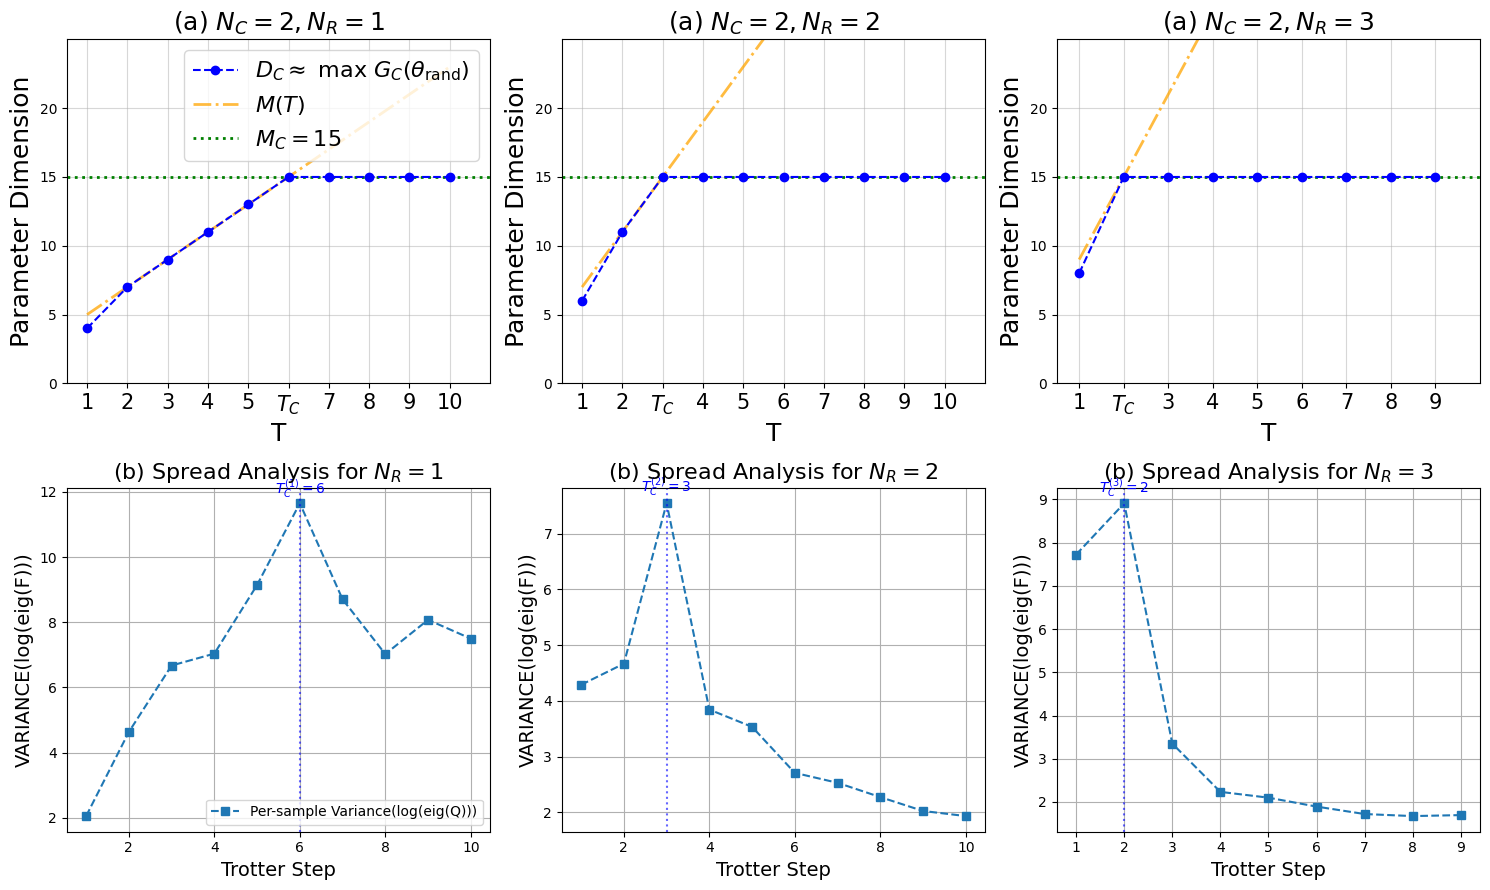

In [148]:
import numpy as np
import matplotlib.pyplot as plt

def plot_many_reserv(df, N_ctrl=2, reserv_list=[1, 2, 3], spread_type="mad"):
    """
    Creates a 2xN grid of subplots, with the top row showing plot_max_rank_vs_params
    and the bottom row showing plot_spread_analysis, each column for a different N_R.

    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing your QFIM info (with 'N_ctrl','N_reserv','Trotter_Step', etc.).
    N_ctrl : int
        The control qubit count to fix for all columns.
    reserv_list : list of int
        The distinct N_reserv values you want to show (e.g. [1, 2, 3]).
    spread_type : str
        'variance' or 'mad', as accepted by your plot_spread_analysis function.

    Returns:
    --------
    fig, axes : The figure and axes objects for further customization.
    """

    # Number of columns is the length of reserv_list
    ncols = len(reserv_list)
    fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(5*ncols, 9), sharex=False, sharey=False)

    # If there is only 1 column, make sure we index axes as 2D
    if ncols == 1:
        # shape would be (2, ) if there's only one column
        axes = np.array([axes]).T  # transform to shape (2,1)

    for col_idx, nr_val in enumerate(reserv_list):
        # ------------------
        # Top row: max-rank vs. T
        # ------------------
        ax_top = axes[0, col_idx]
        plot_max_rank_vs_params(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val, ax=ax_top,
            xlabel="T", ylabel="Parameter Dimension",
            title=f"(a) $N_C={N_ctrl}, N_R={nr_val}$"
        )

        # Hide repeated legends if you only want them once:
        if col_idx > 0:
            ax_top.legend_.remove()

        # ------------------
        # Bottom row: spread analysis
        # ------------------
        ax_bot = axes[1, col_idx]
        plot_spread_analysis(
            df, chosen_n_ctrl=N_ctrl, chosen_n_reserv=nr_val,
            ax=ax_bot, spread_type=spread_type, combination="sampled",
            xlabel="Trotter Step", ylabel=f"{spread_type.upper()}(log(eig(F)))",
            title=f"(b) Spread Analysis for $N_R={nr_val}$"
        )

        if col_idx > 0:
            # Similarly remove legends if you want minimal duplication
            # Or keep them if you prefer each subplot to have its own
            ax_bot.legend_.remove()

    plt.tight_layout()
    return fig, axes

# Example usage:
fig, axes = plot_many_reserv(df_with_stats, N_ctrl=2, reserv_list=[1,2,3], spread_type="variance")

[7, 11, 15, 19, 23, 27, 31, 35, 39, 43]
(1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
[INFO] For N_ctrl=2, N_reserv=2, Detected critical T_C = 3 where M = 15
[INFO] For N_ctrl=2, N_reserv=2, peak T_C is 3



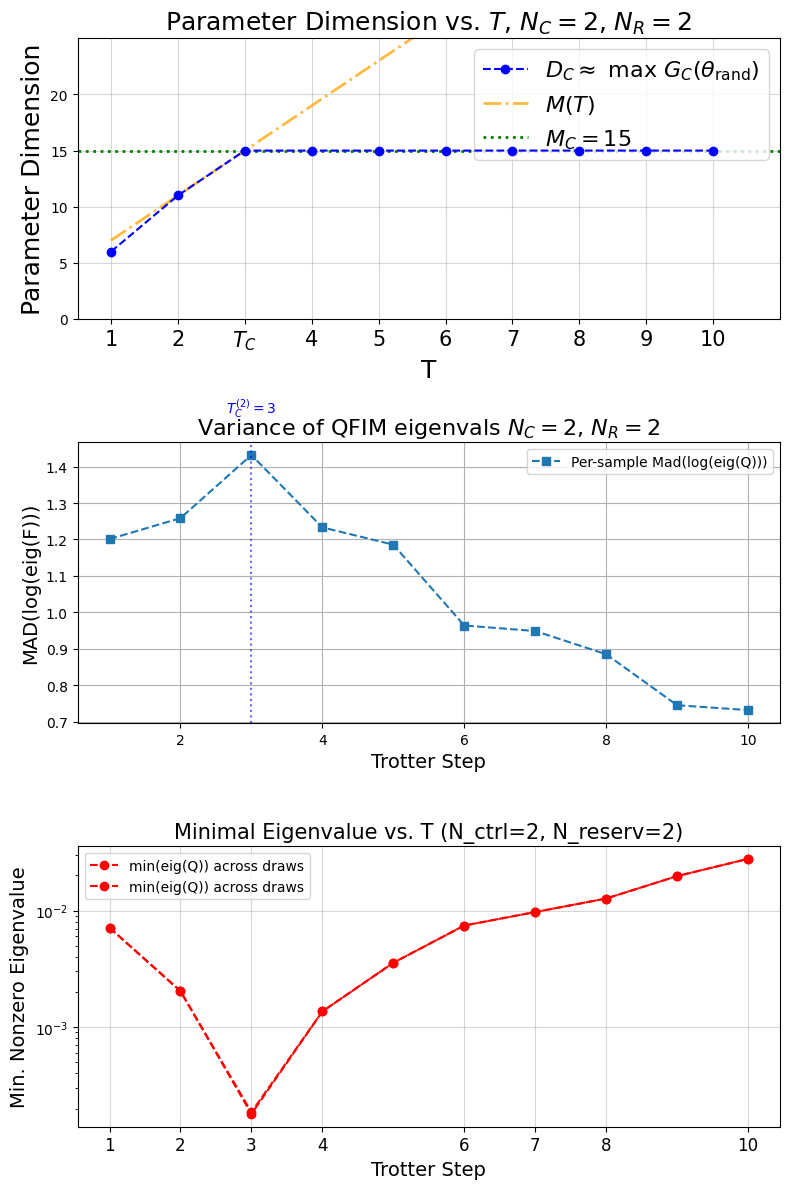

In [92]:
fig, axes = plt.subplots(3, 1, figsize=(8, 12))  # 3 rows: (a), (b), now (c)
# 1) top subplot: your plot_max_rank_vs_params => axes[0]
plot_max_rank_vs_params(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=2, ax=axes[0])

# 2) middle subplot: spread analysis => axes[1]
plot_spread_analysis(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=2, 
                     spread_type="mad", combination="sampled", scale='1.0', ax=axes[1])
# plot_spread_analysis(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=2, 
#                      spread_type="variance", combination="sampled", scale='normal', ax=axes[1])

# 3) bottom subplot: min eigenvalue => axes[2]
plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=2,y_metric='avg_min_nonzero_eigenvalue', chosen_n_reserv=2, ax=axes[2],
                         use_log_y=True, color='r')
plot_min_eigenvalue_vs_t(df_with_stats, chosen_n_ctrl=2,y_metric='min_eigval_from_mean_raw', chosen_n_reserv=2, ax=axes[2],
                         use_log_y=True, color='r')

plt.tight_layout()
plt.show()

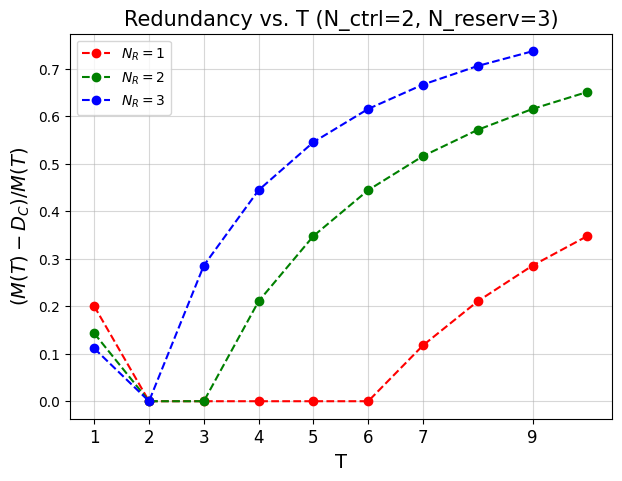

In [147]:
fig2, ax2 = plt.subplots(figsize=(7,5))
plot_redundancy_vs_t(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=1, ax=ax2,color='r')
plot_redundancy_vs_t(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=2, ax=ax2,color='green')
plot_redundancy_vs_t(df_with_stats, chosen_n_ctrl=2, chosen_n_reserv=3, ax=ax2,color='blue')
plt.show()


